Script to calculate coherence, compare between regions, compare between healthy-depressed-stimulation

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
from tvb.simulator.lab import *
import h5py
import os
import matplotlib.pyplot as plt
import pandas as pd

import scipy 
import scipy.fftpack
import seaborn as sns

from scipy.fft import fft, ifft
from scipy import signal

In [3]:
os.chdir("C:/Users/celie/OneDrive - ugentbe/NOG NODIG/2de master/Masterproef/Wilson Cowan/DATA")

In [4]:
#################
# IMPORT DATA   #
#################

#import healthy Q = 1 data    = model with same parameters in all regions
filename = "Healthy10s.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    datapoints = list(f['data'])
    datatime = list(f['time'])

dataHealthyOne = np.array(datapoints)
timeHealthyOne = np.array(datatime)

#import depressed model with Q = 0 in some regions
filename = "Depr10s.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    datapoints = list(f['data'])
    datatime = list(f['time'])

dataDepr = np.array(datapoints)
timeDepr = np.array(datatime)

#import depressed model with Q = 0 in some regions + stimulation applied
filename = "amp0035_tau1.h5"
with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    datapoints = list(f['data'])
    datatime = list(f['time'])

dataStim = np.array(datapoints)
timeStim = np.array(datatime)

Keys: <KeysViewHDF5 ['data', 'time']>
Keys: <KeysViewHDF5 ['data', 'time']>
Keys: <KeysViewHDF5 ['data', 'time']>


In [5]:
#delete first 500ms from datasets (both data and time) to cut out the artefact in the beginning 

#create list with values 0 to 499 to delete first 500 rows 
list_deleterows = [*range(0,500,1)]

#delete first 500 rows from all datasets (both datapoints and time)
dataDepr = np.delete(dataDepr, list_deleterows, 0)
timeDepr = np.delete(timeDepr, list_deleterows, 0)

dataStim = np.delete(dataStim, list_deleterows, 0)
timeStim = np.delete(timeStim, list_deleterows, 0)

dataHealthyOne = np.delete(dataHealthyOne, list_deleterows, 0)
timeHealthyOne = np.delete(timeHealthyOne, list_deleterows, 0)

print(dataDepr.shape)
print(timeDepr.shape)

(9740, 4, 76, 1)
(9740,)


In [6]:
#select correct colomns from datasets (containing the necessary data)
HealthyOne = dataHealthyOne[:, 0, :, 0]
Depressed  = dataDepr[:, 0, :, 0] 
Stim = dataStim[:, 0, :, 0] 

In [7]:
#import connectivity file to know which region corresponds to which index in the matrices
os.chdir("C:/Users/celie/OneDrive - ugentbe/NOG NODIG/2de master/Masterproef/Wilson Cowan/DATA")
filename = "Connectivity.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    regions_list = list(f['region_labels'])

regions = np.array(regions_list)

#make selection of regions to loop through 
indices = [*range(0, 76, 1)] #[13,15,16,18,21,35,36,51,53,54,56,59,73,74]
indices = np.array(indices)

#create list of indices per hemisphere
Lhem_ind = [*range(38, 76, 1)]
Rhem_ind = [*range(0, 38, 1)]

Lhem_ind = np.array(Lhem_ind)
Rhem_ind = np.array(Rhem_ind)


Keys: <KeysViewHDF5 ['areas', 'centres', 'cortical', 'hemispheres', 'orientations', 'region_labels', 'tract_lengths', 'weights']>


In [8]:
#important variables of dataset
sample_period = 0.0009765625 #seconds
sf = 1/sample_period #sampling frequency 
sample_rate = 1024
duration = len(timeDepr)
print(sf)

#sns.set(font_scale=1.2)

1024.0


<IPython.core.display.Javascript object>


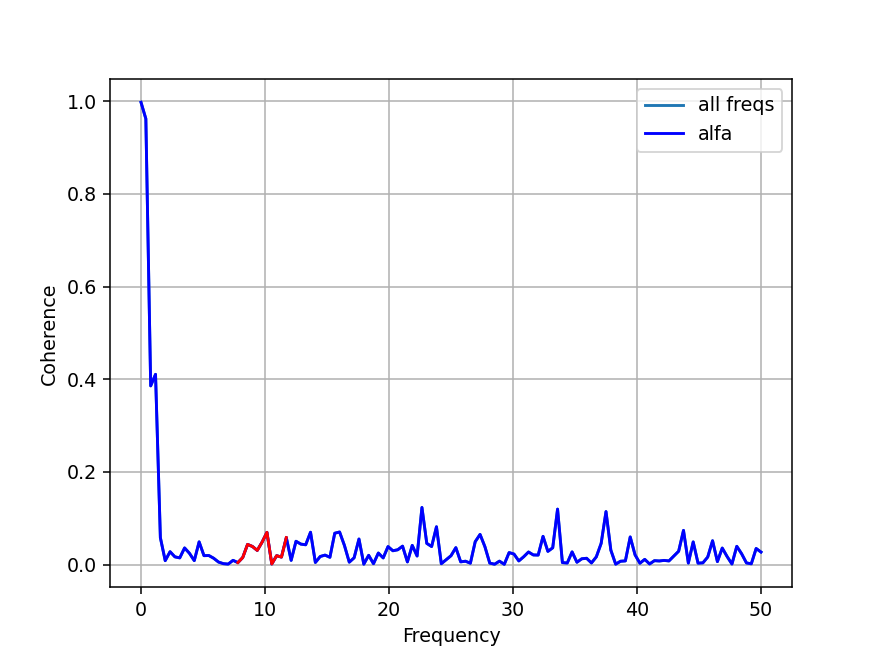

In [9]:
#example coherence plot (in this case: comparing left DLPFC to right DLPFC
dt = 0.01
t = timeHealthyOne

x_h = HealthyOne[:,18]
y_h = HealthyOne[:,56]

cxy_h, f_h = cohere(x_h, y_h, 256, 1. / dt) 

#filter out alfa band (only keep alfa)
f_alf_h = f_h[20:31]
cxy_alf_h = cxy_h[20:31]

plt.plot(f_h, cxy_h, color = "blue")
plt.plot(f_alf_h, cxy_alf_h, color = "red")
plt.legend(["all freqs","alfa"])

fig_name = "example_alfaCoherence.png"
plt.savefig(fig_name, dpi = 300, bbox_inches = "tight")


<IPython.core.display.Javascript object>


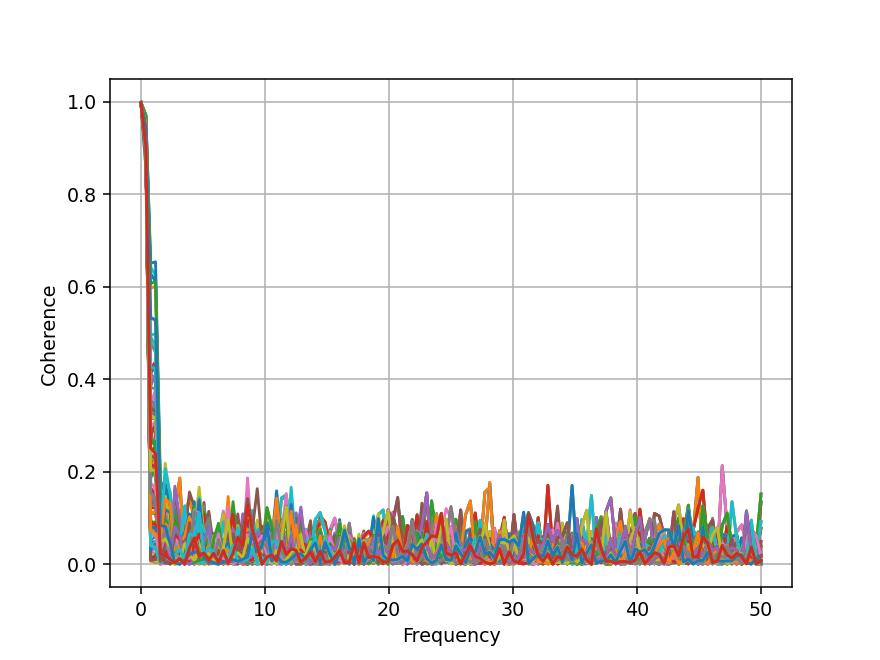

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


<IPython.core.display.Javascript object>


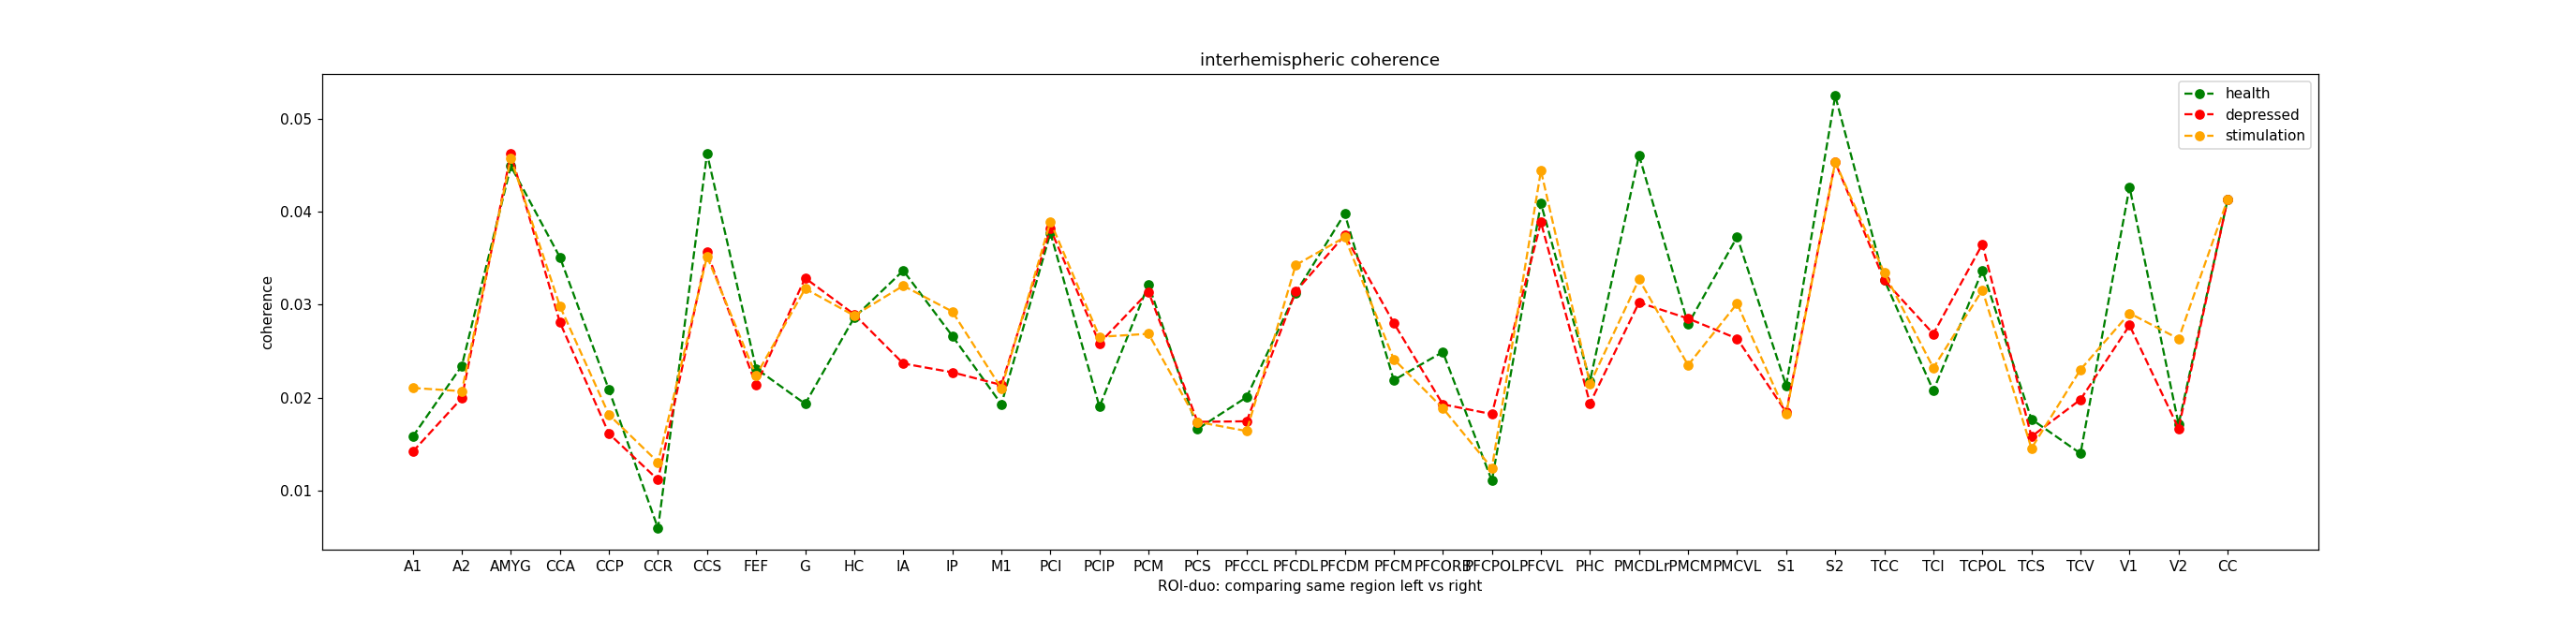

In [10]:
########################################
######## INTERHEMISPHERIC   ############
########################################

Lhem_ind = [*range(38, 76, 1)]
Rhem_ind = [*range(0, 38, 1)]

#coherence between all same regions of different hemispheres

os.chdir("C:/Users/celie/OneDrive - ugentbe/NOG NODIG/2de master/Masterproef/Wilson Cowan/Figures")
mydir = "C:/Users/celie/OneDrive - ugentbe/NOG NODIG/2de master/Masterproef/Wilson Cowan/Figures"
counter = 0

#create emtpy array for InterHemispheric for 38 pairs
arrayIH = np.zeros(shape = (38,5))
dt = 0.01
t = timeHealthyOne

#loop over regions and calculate coherence
lengte = len(Lhem_ind)
for i in range(lengte):
    selectX = Rhem_ind[i]
    selectY = Lhem_ind[i]
    x_h = HealthyOne[:,selectX]
    x_d = Depressed[:,selectX]
    x_s = Stim[:,selectX]

    y_h = HealthyOne[:,selectY]
    y_d = Depressed[:,selectY]
    y_s = Stim[:,selectY]
            
    cxy_h, f_h = cohere(x_h, y_h, 256, 1. / dt) 
    cxy_d, f_d = cohere(x_d, y_d, 256, 1. / dt) 
    cxy_s, f_s = cohere(x_s, y_s, 256, 1. / dt) 
            
    #filter out alfa band (only keep alfa)
    f_alf_h = f_h[20:31]
    cxy_alf_h = cxy_h[20:31]

    f_alf_d = f_d[20:31]
    cxy_alf_d = cxy_d[20:31]
            
    f_alf_s = f_s[20:31]
    cxy_alf_s = cxy_s[20:31]
    
    #store information (region 1, region 2, coherence of the three models)
    arrayIH[counter][0] = selectX
    arrayIH[counter][1] = selectY
    arrayIH[counter][2] = mean(cxy_alf_h) #coherence of healthy brain 
    arrayIH[counter][3] = mean(cxy_alf_d)
    arrayIH[counter][4] = mean(cxy_alf_s)
            
    counter = counter + 1

file_name = mydir + "/interhemispheric.csv"
outcome = pd.DataFrame.from_records(arrayIH)
outcome.columns = ["ROI1", "ROI2", "coh_h", "coh_d", "coh_s"]
outcome.to_csv(path_or_buf = file_name, index = False)

#####################
#PLOTTING
#####################
#coherence value for each ROI-duo (40 duos)
coh_health = arrayIH[:,2]
coh_dep = arrayIH[:,3]
coh_stim = arrayIH[:,4]
x_range = len(coh_health)
x_axis = [*range(0, 38, 1)]
print(x_axis)

labels = ["A1", "A2",'AMYG', 'CCA', 'CCP', 'CCR' ,'CCS', 'FEF', 'G' ,'HC', 'IA',
 'IP' ,'M1', 'PCI', 'PCIP', 'PCM' ,'PCS' ,'PFCCL', 'PFCDL', 'PFCDM',
 'PFCM' ,'PFCORB', 'PFCPOL', 'PFCVL' ,'PHC' ,'PMCDL', 'rPMCM', 'PMCVL',
 'S1' ,'S2' ,'TCC', 'TCI', 'TCPOL' ,'TCS' ,'TCV' ,'V1', 'V2' ,'CC']

#plot the average alfa coherence (extracted from created array) between each pair of regions 
figure(figsize=(25, 6), dpi=80)
plt.plot(labels, coh_health, color = "green",linestyle='--', marker='o')
plt.plot(labels, coh_dep, color  = "red",linestyle='--', marker='o')
plt.plot(labels, coh_stim, color = "orange",linestyle='--', marker='o')
plt.xlabel('ROI-duo: comparing same region left vs right')
plt.ylabel('coherence')
plt.title("interhemispheric coherence")
plt.legend(["health","depressed","stimulation"])
plt.show()

fig_name = "coherence_inter.png" #maak figuur naam op basis van loop
plt.savefig(fig_name, dpi = 300, bbox_inches = "tight")


#interesting points is where orange and green are alike while red is different (would indicate succesful normalization after stimulation)
#based on  image: region 10 en 11 interesting!( = IA en IP); regio 20 ook beetje, 22 ook, 23 beetje, 27 beetje, 31, 32 ook beetje

INTRAHEMISPHERIC: LEFT

In [11]:
#intrahemispheric

#paper knott:
#prefrontal regions vs temporal regions + temporal regions vs parietal regions
#paper Suhhova
#prefrontal (among each other), temporal versus parietal (same as Knott), prefrontal vs occipital 

#prefrontal regions
#PFCcl --> left index = 55  right index = 17
#PFCdl --> left index = 56  right = 18
#PFCdm --> left index = 57  right = 19

#temporal regions
#A1 --> left index = 38, right = 0
#A2 --> left = 39, right = 1
#TCc --> left = 68 , right = 30
#TCi --> left = 69, right = 31
#TCs --> left = 71, right = 32
#TCv --> left = 72, right = 33

#parietal 
# PCI --> left = 51, right = 13
# PCM --> left = 53, right = 15
# PCS --> left = 54, right = 16

#occipital 
#V1 --> left = 73, right = 35
#V2 --> left = 74, right = 36

left_ind = [38, 39, 51, 53, 54, 55, 56, 57, 68, 69, 71, 72, 73, 74]
right_ind = [0, 1, 13, 15, 16, 17, 18, 19, 30, 31, 32, 33, 35, 36]

prefr_left = [55, 56, 57]
temp_left = [38, 39, 68, 69, 71, 72]
par_left = [51, 53, 54]
occ_left = [73, 74]


In [16]:
#frontal vs temporal 
#temporal vs parietal
#prefrontal vs prefrontal 
#prefrontal vs occipital 
#prefrontal vs parietal 

##### LEFT SIDE ######

os.chdir("C:/Users/celie/OneDrive - ugentbe/NOG NODIG/2de master/Masterproef/Wilson Cowan/Figures/Coherence")
mydir = "C:/Users/celie/OneDrive - ugentbe/NOG NODIG/2de master/Masterproef/Wilson Cowan/Figures/Coherence"

#create emtpy array 
array = np.zeros(shape = (58,5)) #increase this to all regions once script is ready!
dt = 0.01
t = timeHealthyOne

#loop for comparisons of frontal regions
counter = 0
for ind1 in left_ind:
    x_h = HealthyOne[:,ind1]
    x_d = Depressed[:,ind1]
    x_s = Stim[:,ind1]
    
    for ind2 in prefr_left:
        if ind1 == ind2:
            pass
        else:
            y_h = HealthyOne[:,ind2]
            y_d = Depressed[:,ind2]
            y_s = Stim[:,ind2]
            
            cxy_h, f_h = cohere(x_h, y_h, 256, 1. / dt) 
            cxy_d, f_d = cohere(x_d, y_d, 256, 1. / dt) 
            cxy_s, f_s = cohere(x_s, y_s, 256, 1. / dt) 
            
            #filter out alfa band (only keep alfa)
            f_alf_h = f_h[20:31]
            cxy_alf_h = cxy_h[20:31]

            f_alf_d = f_d[20:31]
            cxy_alf_d = cxy_d[20:31]
            
            f_alf_s = f_s[20:31]
            cxy_alf_s = cxy_s[20:31]
            
            array[counter][0] = ind1
            array[counter][1] = ind2
            array[counter][2] = mean(cxy_alf_h) #coherence of healthy brain 
            array[counter][3] = mean(cxy_alf_d)
            array[counter][4] = mean(cxy_alf_s)
            
            counter = counter + 1

        
#loop for comparison temporal vs parietal 
for ind1 in temp_left:
    x_h = HealthyOne[:,ind1]
    x_d = Depressed[:,ind1]
    x_s = Stim[:,ind1]
    
    for ind2 in par_left:
        y_h = HealthyOne[:,ind2]
        y_d = Depressed[:,ind2]
        y_s = Stim[:,ind2]
            
        cxy_h, f_h = cohere(x_h, y_h, 256, 1. / dt) 
        cxy_d, f_d = cohere(x_d, y_d, 256, 1. / dt) 
        cxy_s, f_s = cohere(x_s, y_s, 256, 1. / dt) 
            
        #filter out alfa band (only keep alfa)
        f_alf_h = f_h[20:31]
        cxy_alf_h = cxy_h[20:31]

        f_alf_d = f_d[20:31]
        cxy_alf_d = cxy_d[20:31]
            
        f_alf_s = f_s[20:31]
        cxy_alf_s = cxy_s[20:31]
            
        array[counter][0] = ind1
        array[counter][1] = ind2
        array[counter][2] = mean(cxy_alf_h) #coherence of healthy brain 
        array[counter][3] = mean(cxy_alf_d)
        array[counter][4] = mean(cxy_alf_s)
            
        counter = counter + 1
    

file_name = mydir + "/left_hemisphere.csv"
outcome = pd.DataFrame.from_records(array)
outcome.columns = ["ROI1", "ROI2", "coh_h_alfa", "coh_d", "coh_s"]
outcome.to_csv(path_or_buf = file_name, index = False)

<IPython.core.display.Javascript object>


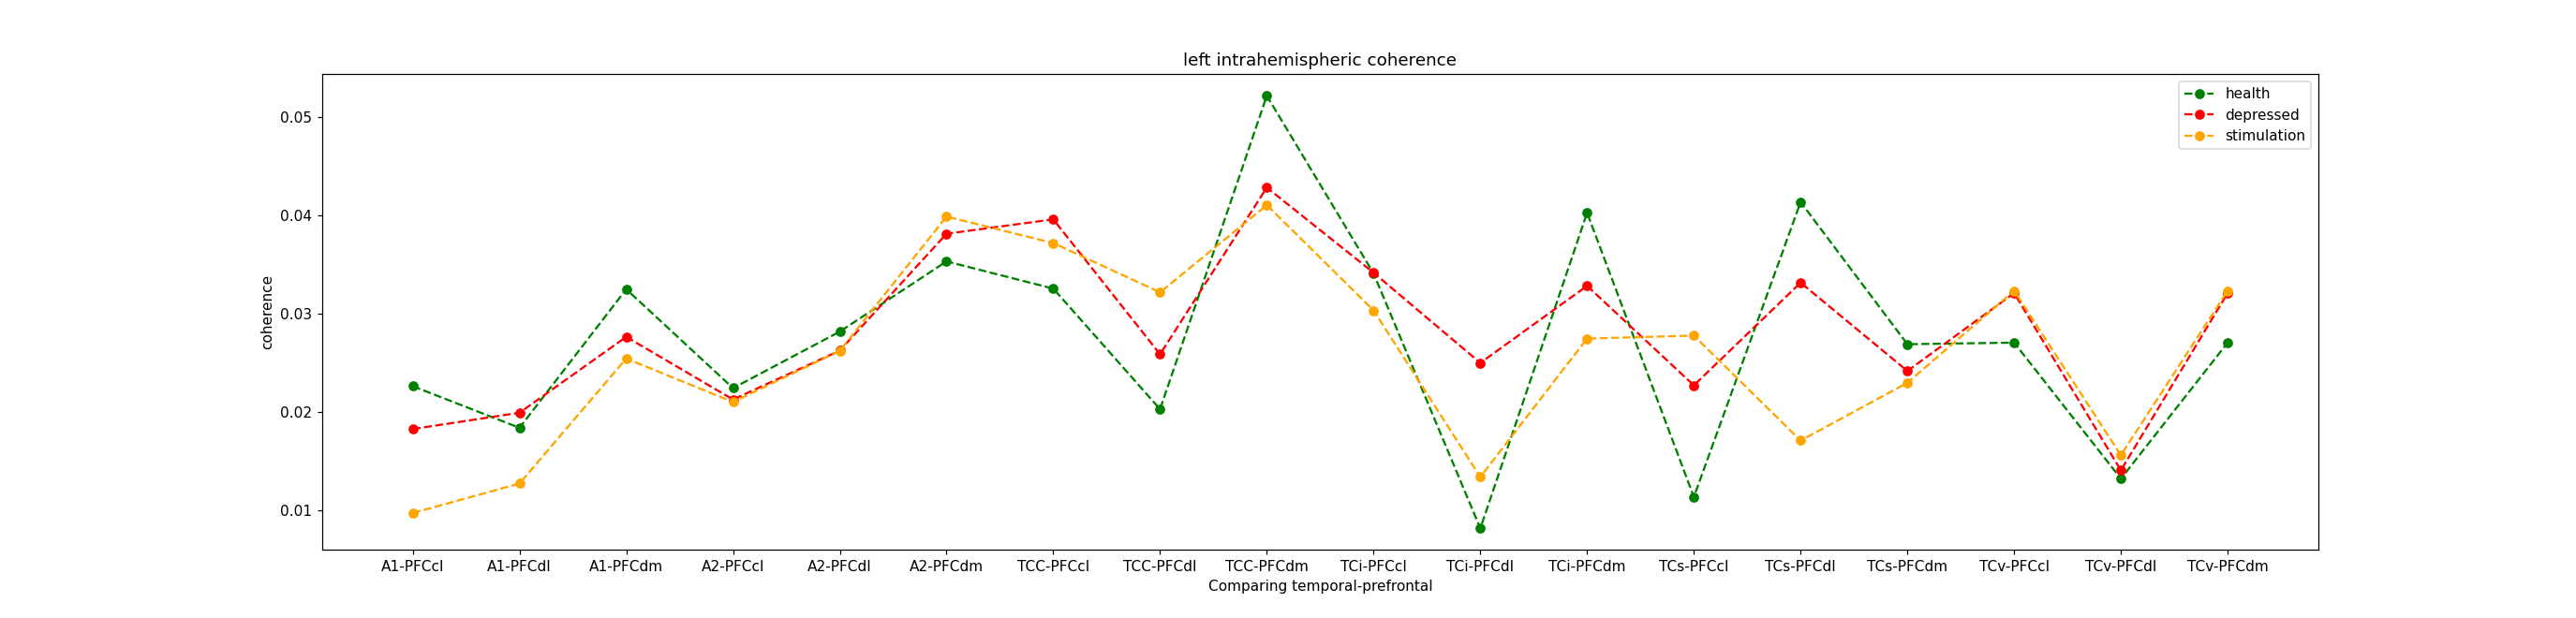

<IPython.core.display.Javascript object>


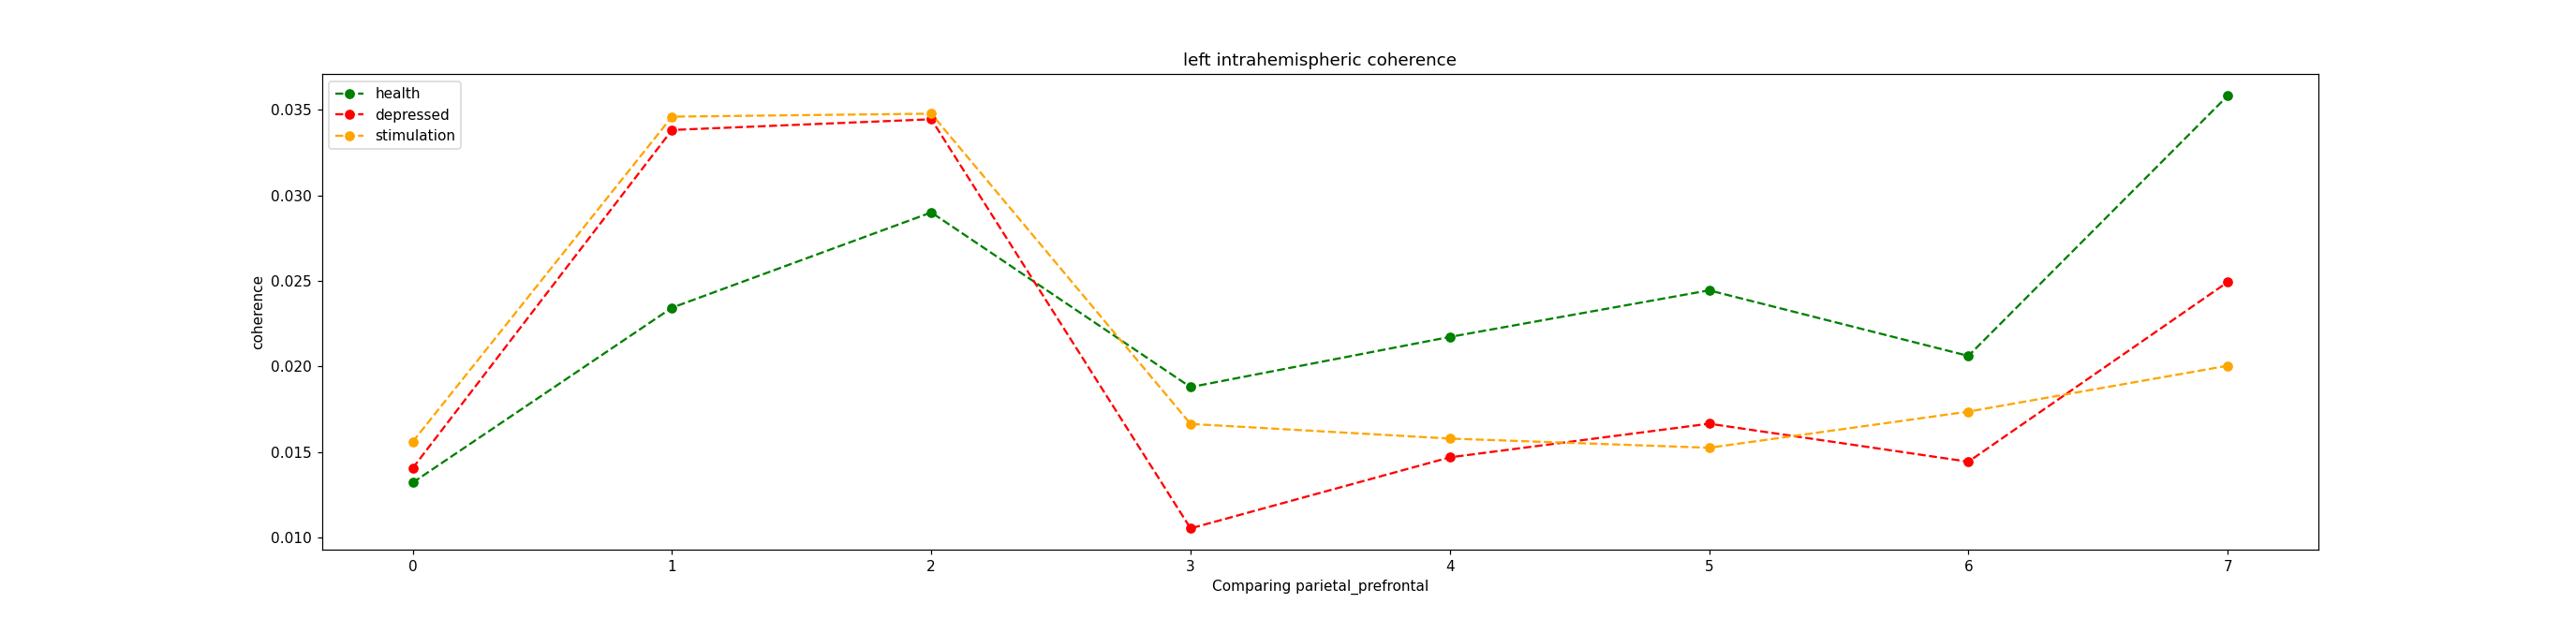

<IPython.core.display.Javascript object>


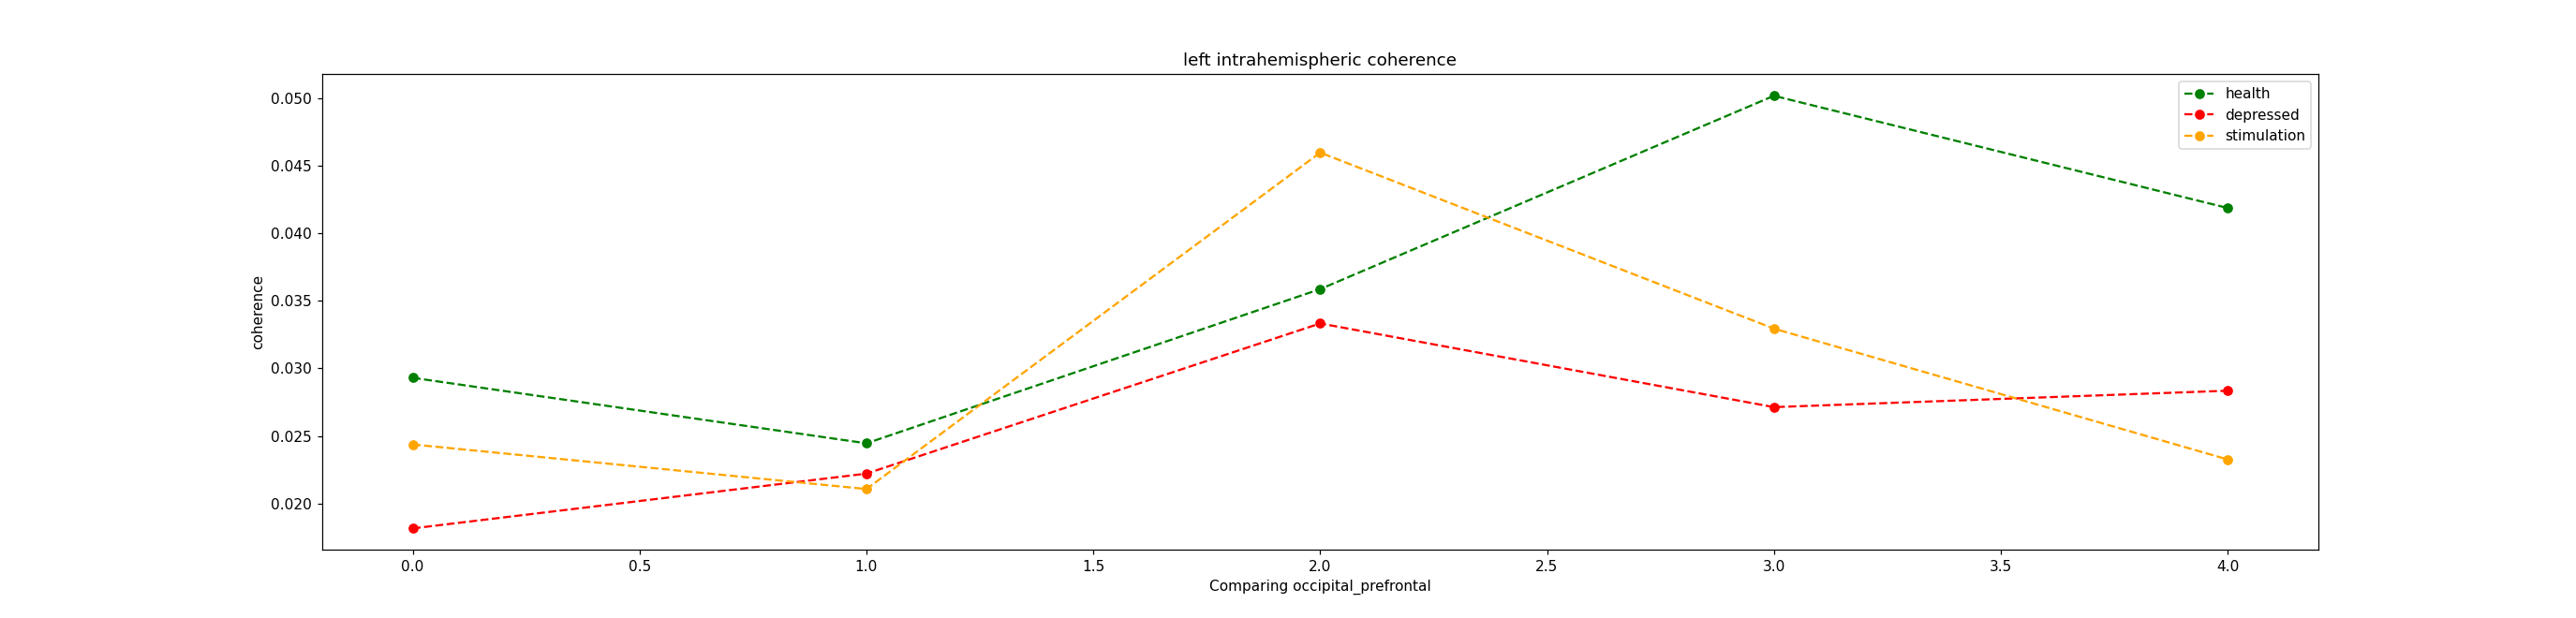

<IPython.core.display.Javascript object>


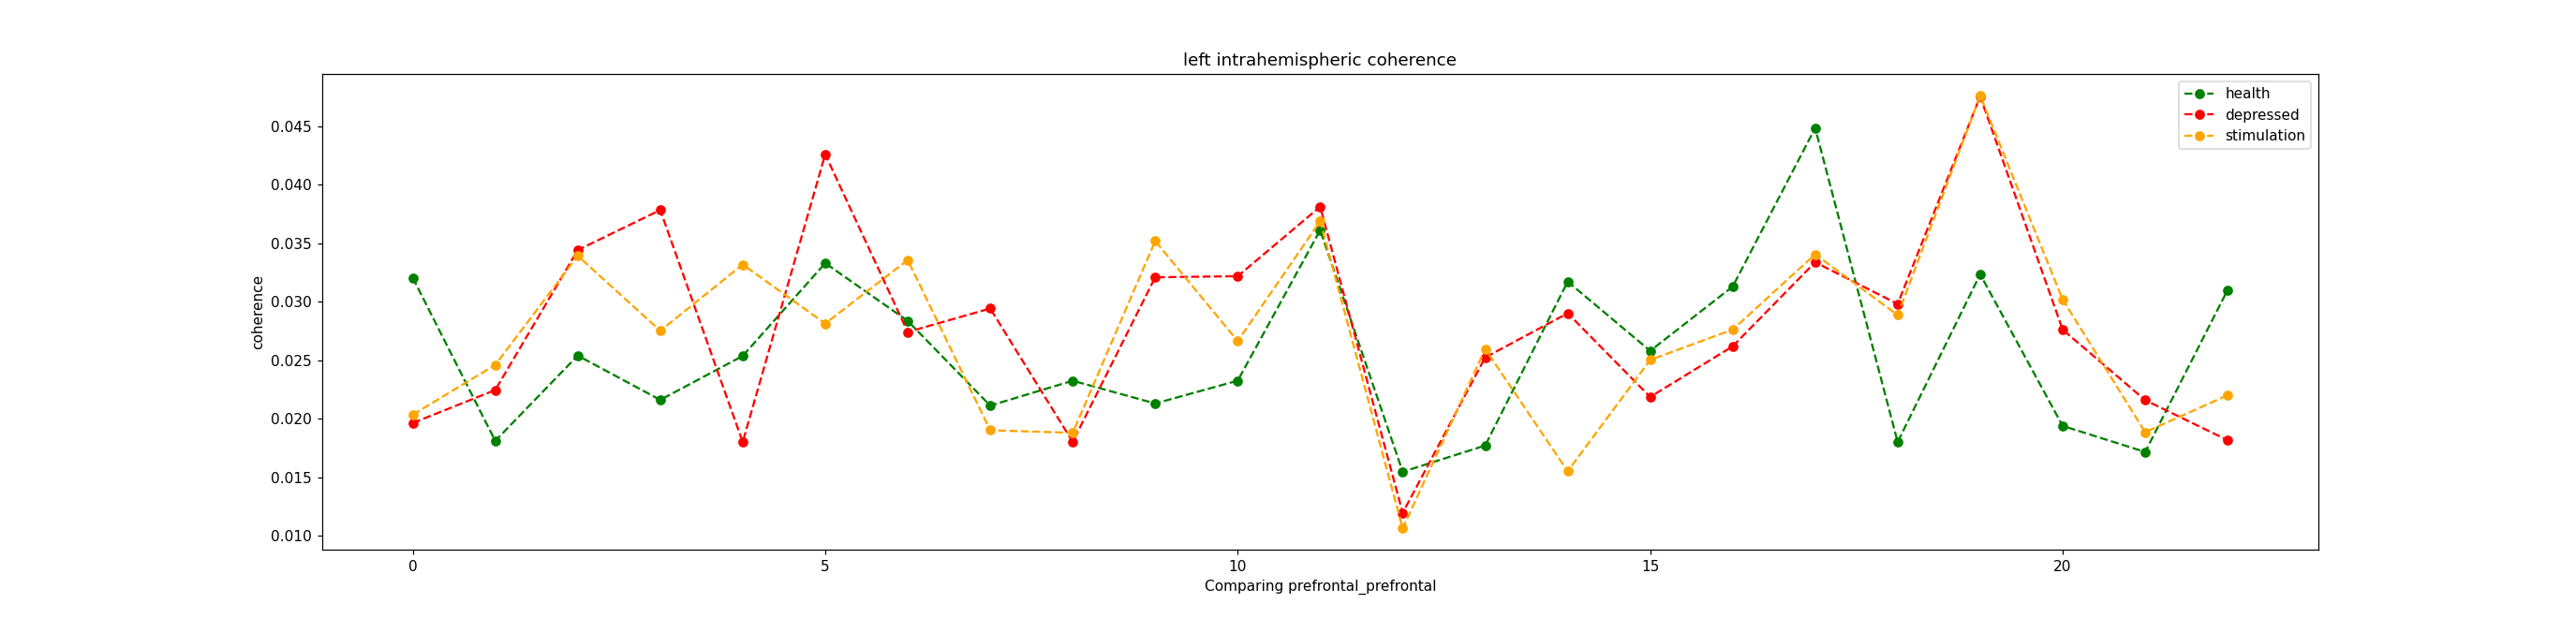

In [17]:
#####################
#PLOTTING
#####################
#coherence value for each ROI-duo 
#create separate arrays for each regions-comparison
temp_pre = array[0:18]  #temp vs prefr
par_pre = array[19:27] #par vs prefr
occ_pre = array[28:33] #occ vs prefr
pre_pre = array[34:57] #prefr vs prefr

#create labels to clear up the plot
labels_temp_pre = ["A1-PFCcl", "A1-PFCdl","A1-PFCdm","A2-PFCcl", "A2-PFCdl","A2-PFCdm","TCC-PFCcl", "TCC-PFCdl","TCC-PFCdm",
                 "TCi-PFCcl", "TCi-PFCdl","TCi-PFCdm","TCs-PFCcl", "TCs-PFCdl","TCs-PFCdm","TCv-PFCcl", "TCv-PFCdl","TCv-PFCdm"]
#still have to make the labels for the other plots

#loop over pairs
for i in range(4):
    if i == 0: array = temp_pre; name = 'temporal-prefrontal'
    elif i == 1: array = par_pre; name = 'parietal_prefrontal'
    elif i == 2: array = occ_pre; name = 'occipital_prefrontal'
    else: array = pre_pre; name = 'prefrontal_prefrontal'
        
    length = len(array)

    coh_health = array[:,2]
    coh_dep = array[:,3]
    coh_stim = array[:,4]
    x_range = len(array)
    if i == 0:
        x_axis = labels_temp_pre
    else:
        x_axis = [*range(0, length, 1)]
    
    #plot the average alfa coherence (extracted from created array in cell before) between each pair of regions 
    figure(figsize=(25, 6), dpi=80)
    plt.plot(x_axis, coh_health, color = "green",linestyle='--', marker='o')
    plt.plot(x_axis, coh_dep, color  = "red",linestyle='--', marker='o')
    plt.plot(x_axis, coh_stim, color = "orange",linestyle='--', marker='o')
    plt.xlabel('Comparing ' + str(name))
    plt.ylabel('coherence')
    plt.title("left intrahemispheric coherence")
    plt.legend(["health","depressed","stimulation"])
    plt.show()

    fig_name = "coherence_left_intra_" + str(name) + ".png" #maak figuur naam op basis van loop
    plt.savefig(fig_name, dpi = 300, bbox_inches = "tight")
